# Project | Natural Language Processing Challenge
### Fake news classifier

Environment

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

"""
import nltk
nltk.download("wordnet")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
"""


'\nimport nltk\nnltk.download("wordnet")\nfrom nltk.corpus import stopwords\nfrom nltk.tokenize import word_tokenize\nfrom nltk.stem import PorterStemmer\nfrom nltk import pos_tag\nfrom nltk.stem import WordNetLemmatizer\nlemmatizer = WordNetLemmatizer()\nstemmer = PorterStemmer()\n'

### Load train and test data


In [12]:
train_data_raw = pd.read_csv(
"training_data_lowercase.csv",
sep="\t",
header=None,
names=["label", "text"]
)
test_data_raw = pd.read_csv(
"testing_data_lowercase_nolabels.csv",
sep="\t",
header=None,
names=["label", "text"]
)

### quick EDA

In [4]:
# preview
display(train_data_raw.head())

# shapes
print(
    f"Training data shape (rows, columns): {train_data_raw.shape}\n"
    f"Test data shape (rows, columns): {test_data_raw.shape}"
)


# fake news / real news balance
print("\nFake news / real news balance:")
print(train_data_raw["label"].value_counts(normalize=True))

# missing values
print("\nMissing values per column:")
print(train_data_raw.isnull().sum())

# empty text check
empty_texts = (train_data_raw["text"].str.strip() == "").sum()
print(f"\nNumber of empty text entries: {empty_texts}")


,label,text
0,0,donald trump sends out embarrassing new year‚s...
1,0,drunk bragging trump staffer started russian c...
2,0,sheriff david clarke becomes an internet joke ...
3,0,trump is so obsessed he even has obama‚s name ...
4,0,pope francis just called out donald trump duri...


Training data shape (rows, columns): (34152, 2)
Test data shape (rows, columns): (9984, 2)

Fake news / real news balance:
label
0    0.514523
1    0.485477
Name: proportion, dtype: float64

Missing values per column:
label    0
text     0
dtype: int64

Number of empty text entries: 0


### Training - validation split

In [5]:
X = train_data_raw["text"]
y = train_data_raw["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

### Data cleaning

In [6]:
# removing only special characters and empty spaces
def clean_text(text):
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

X_train_clean = X_train.apply(clean_text)
X_test_clean  = X_test.apply(clean_text)

Skipping lemmatization on this model. Potential thing to try on next ones.
We chose not to apply lemmatization because:
- Anticipated a low impact based on the nature of the dataset. Not worth the cost
- We could lose nuance in text relevant to fake news style
- Lower impact of lemmatization on TF-IDF 

### Vectorization

In [7]:
# using TF-IDF. Intuitively better suited for fake news detection (emphasis on presence of certain sifnigicant words rather than accumulation of certain words)
tfidf_vectorizer = TfidfVectorizer(
    stop_words="english",
    ngram_range=(1, 2),
    max_features=20000
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_clean)
X_test_tfidf  = tfidf_vectorizer.transform(X_test_clean)

print(f"TF-IDF train shape: {X_train_tfidf.shape}")
print(f"TF-IDF test shape: {X_test_tfidf.shape}")

TF-IDF train shape: (27321, 20000)
TF-IDF test shape: (6831, 20000)


### Model training

In [8]:
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train_tfidf, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### Evaluation

In [9]:
y_pred = model_rf.predict(X_test_tfidf)

y_train_pred = model_rf.predict(X_train_tfidf)

print("Train accuracy:", accuracy_score(y_train, y_train_pred))
print("Test accuracy:", accuracy_score(y_test, y_pred))
print("Classification report:")
print(classification_report(y_test, y_pred))

Train accuracy: 1.0
Test accuracy: 0.922266139657444
Classification report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      3515
           1       0.91      0.93      0.92      3316

    accuracy                           0.92      6831
   macro avg       0.92      0.92      0.92      6831
weighted avg       0.92      0.92      0.92      6831



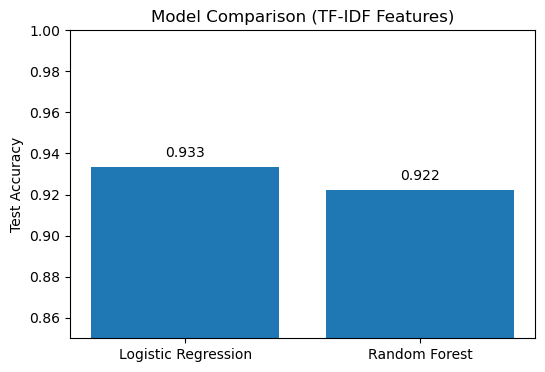

In [13]:
import matplotlib.pyplot as plt

models = ["Logistic Regression", "Random Forest"]
test_accuracies = [0.9335, 0.9223]  # replace with your exact values

plt.figure(figsize=(6,4))
plt.bar(models, test_accuracies)
plt.ylim(0.85, 1.0)
plt.ylabel("Test Accuracy")
plt.title("Model Comparison (TF-IDF Features)")

for i, acc in enumerate(test_accuracies):
    plt.text(i, acc + 0.005, f"{acc:.3f}", ha="center")

plt.show()